<p style="font-size:32px; font-weight: bolder; text-align: center"> Advanced PIMD </p>
<p style="text-align: center"><i> authored by: <a href="mailto:venkat.kapil@gmail.com"> Venkat Kapil </a></i></p>

This notebook provides a hands-on counterpart to the "Advanced PIMD" lecture for the MOOC "Path Integrals in Atomistic Modeling". 

The different sections in this notebook match the parts this lecture is divided into:

1. Total and Kinetic Energy Estimators 
3. Generic Momentum Dependent Operators
4. Efficient Path Integral Calculations

<p style="color:blue; font-weight:bold"> Questions in blue invite you to reflect on the results you are obtaining. If you are doing these notebooks as part of a course, there might be questions to answer relative to those parts. </p>

In [834]:
import numpy as np
import matplotlib.pyplot as plt
import ase, ase.io
import chemiscope
import pimdmooc
pimdmooc.add_ipi_paths()

In [835]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})
# It's also possible to use the reduced notation by directly setting font.family:
plt.rcParams.update({
  "text.usetex": False,
  "font.family": "Helvetica"
})

We will consider a model 3D harmonic system in an external potential 

$U(x, y, z) = \frac{1}{2} m \omega_x^{2} x^2 + \frac{1}{2} m \omega_y^{2} y^2 \quad$ 

with $\omega_x >> k_{\text{B}} T$ and $\omega_y \sim k_{\text{B}} T$. The system can move freely along the z-direction. Therefore, by design, this model system exhibits different magnitues of quantum nuclear effects along the x, y and z Cartesian directions. 

Such a model could characterize a molecular solid or liquid with high frequency modes along the stretching-direction and low frequency modes along the librational or rotational modes. 

In this exercise, we will study the convergence of the system's potential and kinetic energies with different estimators and sampling methods. This exercise is designed to help the user calculate path-integral observables in a computationally efficient manner. 

# EXERCISE 1: Energy Estimators

## Setting up the potential energy surface

To implement the model potential in the i-PI code, we will use the FFDebye machinery of i-PI. This is a fully pythonic function that models a system of uncoupled harmonic oscillators, in the spirit of the [Debye's model](https://en.wikipedia.org/wiki/Debye_model) for solid. The total potential is written as 

$U^{\text{DEBYE}} = \frac{1}{2}\left(\mathbf{q} - \mathbf{q}_0\right) \mathsf{K} \left(\mathbf{q} - \mathbf{q}_0\right)$

Here, $\mathbf{q}$ is a vector or row matrix of the positions of the particles, $\mathbf{q}_0$ is a reference position, and $\mathbf{K}$ is the force-constant or the Hessian matrix. 

The FFDebye model can be implemented in i-PI using the following xml tags in the simulation tag:

```xml
<ffdebye name='debye'>
  <hessian shape='(3,3)' mode='file'> HESSIAN_FILE </hessian>
  <x_reference mode='file'> POS_REFERENCE_FILE  </x_reference>
</ffdebye>
```

where HESSIAN_FILE is to be replaced by a file containing the Hessian matrix and *POS_REFERENCE_FILE* is to be replaced by a file containing the $\mathbf{q}_0$ position vector. This can be linked to the system's physical forces in the same manner as a stanadard forcefield socket:

```xml
  <system>
    ....
    ....  
    <forces>
      <force forcefield='debye'> </force>
    </forces>
    ....
    ....
  </system>
```

Lets set the mass, $k_{\text{B}}$, and temperature to unity and $\omega_x = 16$ and $\omega_y = 4$. The potential can be set using the hessian matrix,

```xml
256 0 0
0  16 0
0  0 0
```

as saved in the "3-advanced-pimd/hessian.data" file,
and the reference positions,

```xml
0 0 0
```

as saved in the "3-advanced-pimd/ref.data". The mass can be set to unity in the initializer tag of the input file 

```xml
<initialize nbeads='1'>
    ...
    <masses mode='manual'> [1.0] </masses>
    ...
</initialize>
```

and the temperature to unity in the ensemble tag

```xml
<ensemble>
    ...
    <temperature> 1 </temperature>
    ...
</ensemble>
```

You can look at these files and the input.xml file using standard bash commands

```
$ cat 3-advanced-pimd/hessian.data
$ cat 3-advanced-pimd/hessian.data
$ cat 3-advanced-pimd/template_input.xml
```

## Analytic Solution

The quantum canonical partition function of a 2D system in an external potential 

$U(x, y) = \frac{1}{2} m \omega_x^{2} x^2 + \frac{1}{2} m \omega_y^{2} y^2 \quad$ \

can be written as, 

$Z = Z_{x} Z_{y} = \frac{1}{2}\text{Csch}\left(\frac{\beta \hbar \omega_{x}}{2}\right) \times \frac{1}{2}\text{Csch}\left(\frac{\beta \hbar \omega_{y}}{2}\right),$ 

the product of the quantum partition functions of the harmonic oscillators along x and y directions. 

The total energy of the system is determined from the relation

$E = -(\frac{\partial \ln{Z}}{\partial \beta}) = \frac{\hbar \omega_{x}}{2} \frac{1 + e^{-\beta \hbar \omega_{x}}} {1 - e^{-\beta \hbar\omega_{x}}} +  \frac{\hbar \omega_{y}}{2} \frac{1 + e^{-\beta \hbar \omega_{y}}} {1 - e^{-\beta \hbar\omega_{y}}}$

Let's define a function for the energies of the harmonic oscillators and the total energy of the system!

In [836]:
def Ethermo_harm(omega, beta):
    """
    Returns the thermodynamic energy of a harmonic oscillator 
    with frequency :omega: in the canonical ensemble 
    at inverse temperature :beta:. 
    """
       
    return omega / 2  * (1 + np.exp(-beta * omega)) / (1 - np.exp(-beta * omega)) 


def Ethermo(omegas, beta):
    """
    Returns the thermodynamic energy of the 2D model at
    at inverse temperature :beta:. 
    """
    
    return Ethermo_harm(omegas[0], beta) + Ethermo_harm(omegas[1], beta)

Now let's look at the how the system's total energy changes with temperature. 

<p style="color:blue; font-weight:bold">  Can you modify the following snippet to also also plot the temperature dependence of the x and y components of the energy? Can you comment whether the system resides in its ground or excited states at $\beta = 1$ along the x and y direction? </p>

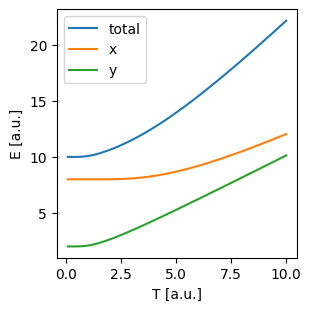

In [837]:
ts = np.linspace(0.1, 10)
energies_x = Ethermo_harm(16, 1/ts)
energies_y = Ethermo_harm(4, 1/ts)
energies = Ethermo([16, 4], 1/ts)

fig, ax = plt.subplots(1,1 ,figsize=(3,3), sharex = True, sharey = True, constrained_layout=True)

ax.set_ylabel('E [a.u.]')
ax.set_xlabel('T [a.u.]')

ax.plot(ts, energies, label='total') #comment 
ax.plot(ts, energies_x, label='x') #comment
ax.plot(ts, energies_y, label='y') #comment


ax.legend()

<p style="color:blue; font-weight:bold"> Our system exhibits harmonic and free particle motion along the x, y, and z direction and therefore satisfies the equipartition principle. Can you estimate the system's kinetic energy at $\beta=1 ?$ </p>




In [838]:
Eref = Ethermo([16, 4], 1) / 2  + 0.5 # comment
print (Eref, ' a.u.')

5.537315621009047  a.u.


## Calculating the kinetic energy using PIMD 

Let's calculate the kinetic energy of this system using PIMD. We will first study the convergence of the primitive and virial kinetic energy as a function of the number of replicas. And, subsequently, we will compare the statistical performance of the primitive and virial kinetic energy estimators. 

To calculate the quantum kinetic energy of the model system using the i-PI code, we will first create an appropriate folder, create a separate working directories for calculations with different replicas, copy the template_pimd.xml file and and edit it to reflect the correct number of replicas. 

You will need to open a terminal and execute

```
$ 2-advanced-pimd
$ mkdir exercise-1
$ cd exercise-1
$ mkdir P.01
$ cd P.01
$ cp ../../template_pimd.xml input.xml
```
and then set the number of replicas to 1. You have to repeat this procedure creating directories P.02, P.04. P.08, P.16, P.32, and P.64 and modifying the number of replicas appropriately.

Since the PES is implemented using the intrinsic FFDebye mode no addition driver is needed! You can perform the i-pi simulations by running 

```
$ i-pi input.xml > log.i-pi &
```

in the individual directories. The i-PI input file's property section reads:

```xml
<output prefix='simulation'>
  <properties filename='out' stride='100'> 
  [ step, time, conserved, temperature, kinetic_cv, kinetic_td, potential ] 
  </properties>
  ...
</output>

```

indicating that the 5th and 6th columns of the simulation.out files contain the centroid-virial and primitive (thermodynamic) kinetic energies estimator values. 

In the snippet below, the instantenous primitive kinetic energy estimator is printed as a function of time and some code is provided to calculate the average and (approximate) statistical error in the kinetic energy. 

# Number of replicas, Average Kinetic Energy, Statistical Error in the Kinetic Energy 
# 1.0 1.5 0.0
# 2.0 2.207962269108891 0.027417084044154456
# 4.0 3.183529399138176 0.04806848498548939
# 8.0 4.308990951768012 0.08172680453609678
# 16.0 5.207247415074725 0.1285362051852772
# 32.0 5.841479042044045 0.20004708877039148
# 64.0 5.277105967469091 0.3150564390580967


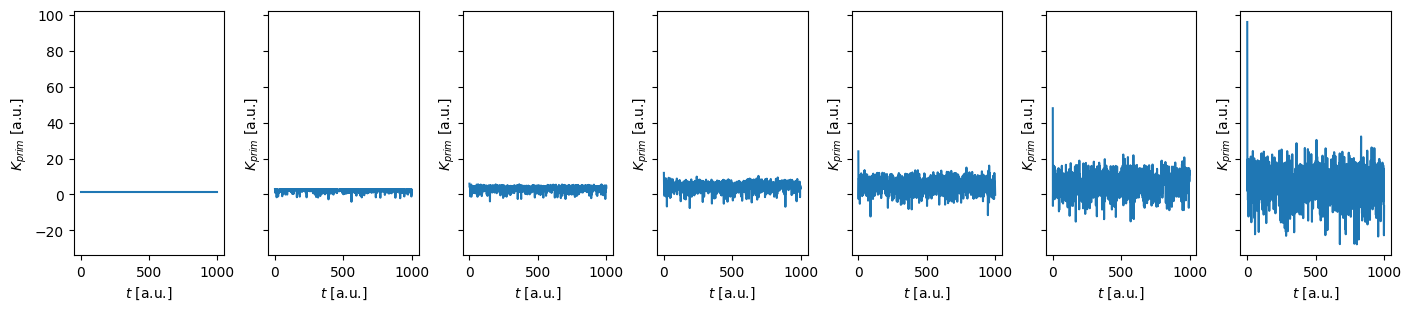

In [839]:
P_list = []
Kprimavg_list = []
Kprimerr_list = []


print ("# Number of replicas, Average Kinetic Energy, Statistical Error in the Kinetic Energy ")
fig, ax = plt.subplots(1,7,figsize=(14,3), sharex = True, sharey = True, constrained_layout=True)
for i, P in enumerate(['01', '02', '04', '08', '16', '32', '64']):
    traj = pimdmooc.read_ipi_output('3-advanced-pimd/exercise-1/P.' + P + '/simulation.out')
    ax[i].plot(traj["time"], traj["kinetic_td"], ls="-")
    ax[i].set_xlabel(r"$t$ [a.u.]"); 
    ax[i].set_ylabel(r"$K_{prim}$ [a.u.]");
    
    print ("#", float(P), np.mean(traj["kinetic_td"]), np.std(traj["kinetic_td"]) / np.sqrt(len(traj["kinetic_td"])))
    
    P_list.append(float(P))
    Kprimavg_list.append(np.mean(traj["kinetic_td"]))
    Kprimerr_list.append(np.std(traj["kinetic_td"]) / np.sqrt(len(traj["kinetic_td"])))

<p style="color:blue; font-weight:bold">  Can you adapt the above snippet to print the timeseries of the centroid-virial kinetic energy? </p>

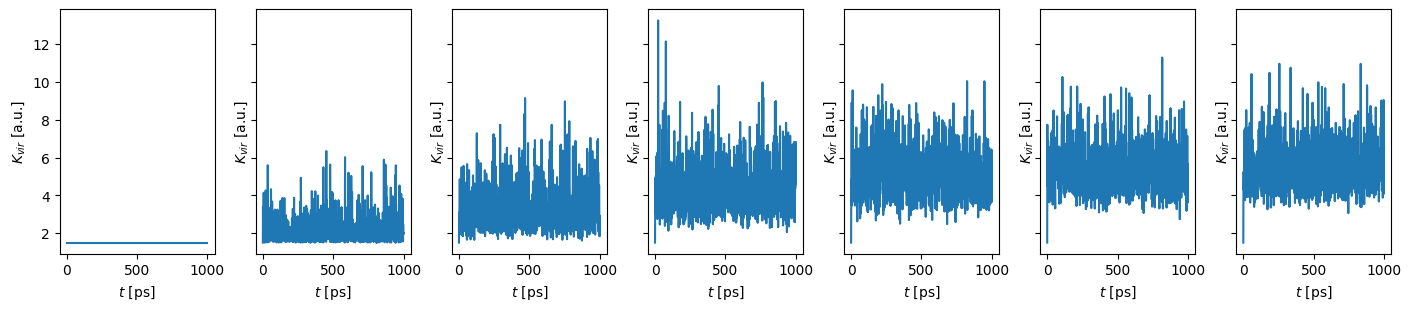

In [840]:
P_list = []
Kviravg_list = []
Kvirerr_list = []

fig, ax = plt.subplots(1,7,figsize=(14,3), sharex = True, sharey = True, constrained_layout=True)
for i, P in enumerate(['01', '02', '04', '08', '16', '32', '64']):
    traj = pimdmooc.read_ipi_output('3-advanced-pimd/exercise-1/P.' + P + '/simulation.out')
    ax[i].plot(traj["time"], traj["kinetic_cv"], ls="-")
    ax[i].set_xlabel(r"$t$ [ps]"); 
    ax[i].set_ylabel(r"$K_{vir}$ [a.u.]");
    
    P_list.append(float(P))
    Kviravg_list.append(np.mean(traj["kinetic_cv"]))
    Kvirerr_list.append(np.std(traj["kinetic_cv"]) / np.sqrt(len(traj["kinetic_td"])))

<p style="color:blue; font-weight:bold">  Can you plot the average kinetic energy (with statistical error) as a function of the number of replicas for both the estimators? How many replicas do you need to visibly converge the kinetic energy ? </p>

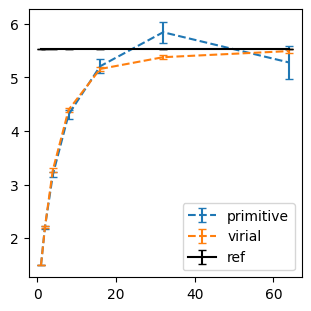

In [841]:
fig, ax = plt.subplots(1,1, figsize=(3,3), sharex=True, sharey=True, constrained_layout=True)
ax.errorbar(P_list, Kprimavg_list, Kprimerr_list, capsize=3, ls='--', label='primitive')
ax.errorbar(P_list, Kviravg_list, Kvirerr_list, capsize=3, ls='--', label='virial')
ax.errorbar(P_list, np.asarray(Kviravg_list) * 0 + Eref, np.asarray(Kvirerr_list) * 0, capsize=3, ls='-', label='ref', c='k')
ax.legend()


<p style="color:blue; font-weight:bold">  Can you plot the statistical error in  kinetic energy as a function of the number of replicas for both the estimators? Can you identify their scaling relation? </p>

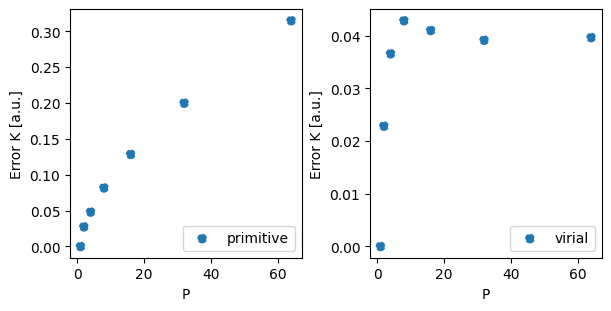

In [842]:
fig, ax = plt.subplots(1,2,figsize=(6,3), sharex = True, sharey = False, constrained_layout=True)
ax[0].scatter(P_list, Kprimerr_list, ls='--', label='primitive')
ax[0].set_xlabel('P')
ax[0].set_ylabel('Error K [a.u.]')
ax[1].set_ylabel('Error K [a.u.]')
ax[0].legend(loc='lower right')
ax[1].scatter(P_list, Kvirerr_list, ls='--', label='virial')
#ax[0].scatter(P_list, np.asarray(Kvirerr_list) * 0.00 + 0.09 + 0.22 / 60 * np.asarray(P_list), ls='--', label='virial')
ax[1].set_xlabel('P')
ax[1].legend(loc='lower right')

## EXERCISE 2: Particle Momentum Distribution

## Setting up the calculation

Let's calculate the momentum distribution of the system along the x-direction using the primitive and the scaled gradient approaches. 

To simulate open-chain paths using the i-PI code, we will first create an appropriate folder copy the template_opimd.xml file and and edit it to reflect the correct number of replicas. Instead of studying the convergence of the momentum distribution you can use P=64. 

You will need to open a terminal and execute

```
$ 2-advanced-pimd
$ mkdir exercise-2
$ cd exercise-2
$ mkdir P.64
$ cd P.64
$ cp ../../template_opimd.xml input.xml
```
and then set the number of replicas to 64. You can perform the i-pi simulations by running 

```
$ i-pi input.xml > log.i-pi &
```

The property section of the file reads 

```xml
    ...
    <properties filename='pos' stride='100'> [ atom_x(0;0), atom_x(0;-1) ] </properties>
    <trajectory filename='for' stride='100'> forces </trajectory>
    ...

````

It prints out the 0-th and -1-th (the last) replica of the system into the simulation.pos file and forces acting on all the replicas in trajectory formatted output files. These two files can be used to calculate both the primitve and the scaled gradient estimators!

<p style="color:blue; font-weight:bold">  The system lies in the ground state of the oscillator along the x-coordinate therefore its kinetic energy is half the zero-point energy. Knowing that a harmonic system exhibits a Gaussian distribution for its momenta, what should be the standard deviation of the distribution for it to have the correct kinetic energy? Can you plot the system's momentum distribution? </p>
<p style="color:blue; font-weight:bold">  <i> Hint: the second moment of the distribution times 0.5 should be the kinetic energy of the system </i> </p>

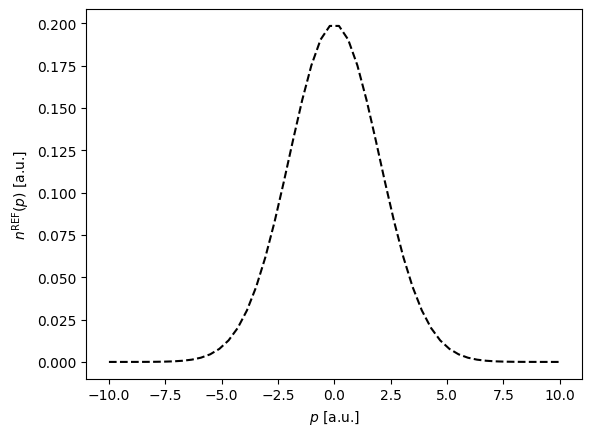

In [843]:
s = 2 #  work out the correct value of s

p = np.linspace(-10,10)

plt.xlabel('$p$ [a.u.]')
plt.ylabel(r'$n^{\mathrm{REF}}(p)$ [a.u.]')
plt.plot(p, np.exp(-p**2/2/s**2) /np.trapz(np.exp(-p**2/2/s**2), p), label='ref', c='k', ls='--')

## The primitive momentum distribution estimator

The following code snippet calculates the Fourier transform of a real signal. Let's use this to calculate the primitive momentum distribiution of the system along the x-direction!

In [844]:
def real_fourier(signal, domain):
    """
    Returns the Fourier transform of a real one dimensional signal
    in given domain.
    """
    
    ft_domain = np.zeros(len(signal) + 1)
    ft = np.zeros(len(signal) + 1)
    
    rfft = abs(np.fft.rfft(signal))
    rfft_domain = np.fft.rfftfreq(len(signal), domain[1] - domain[0]) * np.pi
    
    ft_domain[0:len(rfft_domain)] = -1.0 * rfft_domain[::-1]
    ft_domain[len(rfft_domain) - 1:] = rfft_domain
    ft[0:len(rfft_domain)] = rfft[::-1]
    ft[len(rfft_domain) - 1:] = rfft
        
    return ft_domain, ft

The following snippet reads the simulation.pos file containing the 3D coordinates of the two ends of the path integral. It calculates and plots the histogram of the end to end distance along x. It also utlizies the symmetry of the momentum distribution about the origin to smoothen the histogram. Study the code carefully.

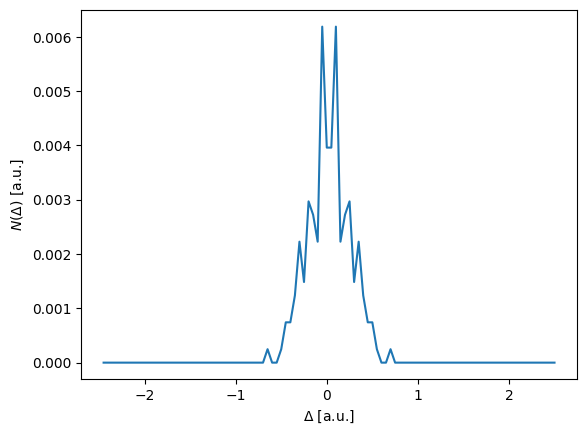

In [845]:
P = 64
q = np.loadtxt('3-advanced-pimd/exercise-2/P.' + str(P) + '/simulation.pos', usecols=(0,3))

d = q.T[0] - q.T[1]

h, e = np.histogram(d, 100, density=True, range=(-2.5,2.5))
h = h /2 + h[::-1] /2
h = h / np.sum(h) * (e[1]-e[0])

plt.plot(e[1:], h)
plt.xlabel('$\Delta$ [a.u.]')
plt.ylabel('$N(\Delta)$ [a.u.]')
plt.show()

<p style="color:blue; font-weight:bold"> What should be analytic form of the end-to-end estimator for the system along x? Does the calculated histogram visibly resemble the expected functional form? Can you plot it? </p> 
<p style="color:blue; font-weight:bold">  <i> Hint: Fourier transform of a Gaussian is a Gaussian. </i> </p>

<p style="color:blue; font-weight:bold"> What kind of artefacts can you observe in the calculated momentum distribution? Can you complete the code below to plot the momentum distribution from the end to end histogram using the real_fourier code?  </p> 

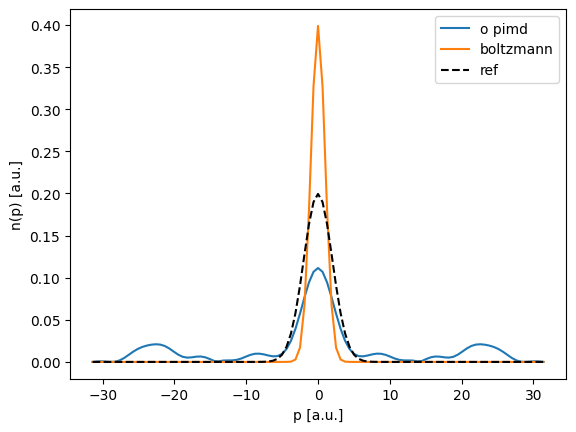

In [846]:
p, ft1  = real_fourier(h, e[1:])
ft1 = ft1  / np.trapz(ft1, p)

plt.plot(p, ft1, label='o pimd')
plt.xlabel('p [a.u.]')
plt.ylabel('n(p) [a.u.]')
plt.plot(p,  np.exp(-p**2/2) / (np.sqrt(2 * np.pi)), label='boltzmann')
s = 2;
plt.plot(p, np.exp(-p**2/2/s**2) /np.trapz(np.exp(-p**2/2/s**2), p), label='ref', c='k', ls='--')
plt.legend()
plt.show()

## Scaled gradient momentum distribution estimator

The following snippet estimates the scaled gradient  estimator by obtaining a more converged derivative of the end-to-end distribution using the forces acting on all the replicas, (anti) symmetrizing the distribution and numerically integrating it to obtain end-to-end distribution. Note that integration of the function is only to help visualize the distribution. The momentum distribution can also be calculated directly from the derivative!

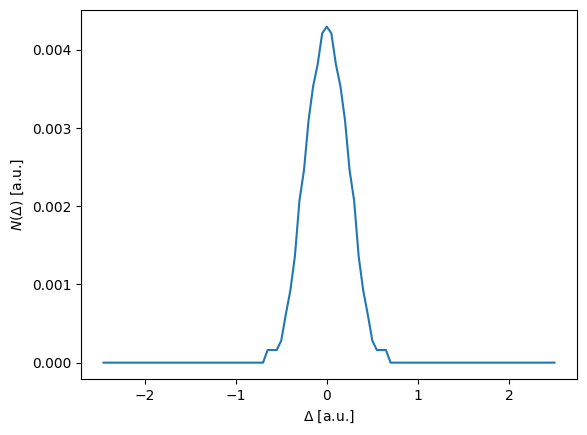

In [847]:
P = 64
f = []
l = np.linspace(-0.5,0.5,P)
sigma_P = np.sqrt(1/P)

for x in range(P):
    
    x = str(x).zfill(2)
    f.append(np.asarray([tmp.positions.T[0] for tmp in pimdmooc.read_ipi_xyz('3-advanced-pimd/exercise-2/P.64/simulation.for_' + x + '.xyz')]).flatten())

q = np.loadtxt('3-advanced-pimd/exercise-2/P.' + str(P) + '/simulation.pos', usecols=(0,3))
f = np.array(f)
d = q.T[0] - q.T[1]
g = (d / sigma_P**2) + np.dot(f.T, l) / P 

h, e = np.histogram(d, 100, weights=g, density=True, range=(-2.5,2.5))
h = h / 2 - h[::-1] / 2

h = np.cumsum(h) * (e[1]-e[0])
h = h / np.sum(h) * (e[1]-e[0])

plt.plot(e[1:], h)
plt.xlabel('$\Delta$ [a.u.]')
plt.ylabel('$N(\Delta)$ [a.u.]')
plt.show()

<p style="color:blue; font-weight:bold"> Do you see an improvement in the modeling of the end-to-end estimator? Can you now modify the snippet below to estmate the momentum distribution? </p>  

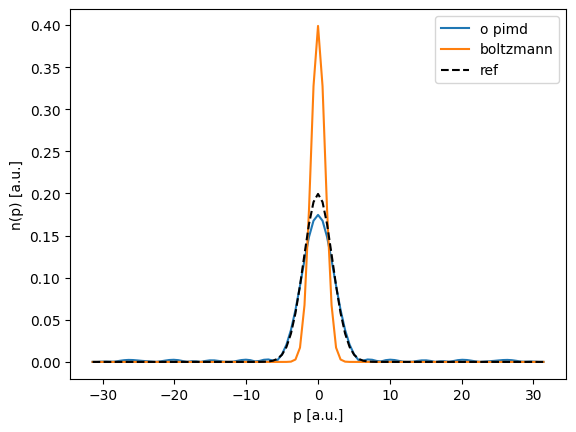

In [848]:
p, ft2 = real_fourier(h, e[1:])
ft2 = ft2 / np.trapz(ft2, p)
plt.plot(p, ft2, label='o pimd')
plt.xlabel('p [a.u.]')
plt.ylabel('n(p) [a.u.]')
plt.plot(p,  np.exp(-p**2/2) / (np.sqrt(2 * np.pi)), label='boltzmann')
plt.plot(p, np.exp(-p**2/2/s**2) /np.trapz(np.exp(-p**2/2/s**2), p), label='ref', c='k', ls='--')
plt.legend()
plt.show()

<p style="color:blue; font-weight:bold"> Can you comment on the quality of the momentum distributions from the primitive and scaled gradient estimators? Do you think the errors increase or decrease the predicted average kinetic energy? </p>  

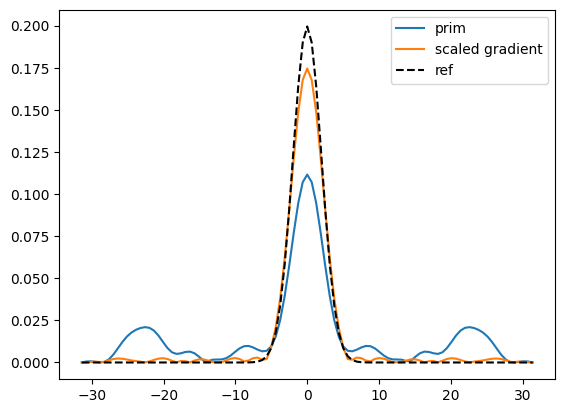

In [850]:
s = 2
plt.plot(p, ft1, label ='prim')
plt.plot(p, ft2, label ='scaled gradient')
plt.plot(p, np.exp(-p**2/2/s**2) /np.trapz(np.exp(-p**2/2/s**2), p), label='ref', c='k', ls='--')
plt.legend()
plt.show()

## EXERCISE 3: Efficient Path Integral Calculation

## Ring Polymer Contraction

As you can see converging a thermodynamical property of a system using PIMD requires simulations of many ($P$) replicas of the system and therefore atleast a $P$ times increased cost compared to a classical simulation. In this exercise, we will demonstrate the ring polymer contraction method, that uses range-separation of a potential into slow and fast components. 

Often the low frequency (long ranged) interactions are much more expensive than the short ranged ones and, in isolation, require fewer replicas for convergence. However, together with high-frequency modes, that require more replcias, the more expensive slow components end up being evaluated more number of times than needed. 

The ring polymer contraction algorithm allows one to use different number of replicas for different components of the potential. For instance, checkout the template_rpc.xml file and look at the system's force field tags,

```xml
  <ffdebye name='fast'>
    <hessian shape='(3,3)' mode='file'> ../../hessian-fast.data </hessian>
    <x_reference mode='file'> ../../ref.data  </x_reference>
  </ffdebye>

  <ffdebye name='slow'>
    <hessian shape='(3,3)' mode='file'> ../../hessian-slow.data </hessian>
    <x_reference mode='file'> ../../ref.data  </x_reference>
  </ffdebye>
  <system>

```

which defined different force-providers for slow and fast components. The hessian-fast.data file sets $\omega_y$ to zero while the hessain-slow.data file sets $\omega_x$ to zero. The sum of these two potentials is same as the potential in exercise-1. Now study the system's forces tag,

```xml
    <forces>
      <force forcefield='debye-fast' nbeads='32'> </force>
      <force forcefield='debye-slow' nbeads='1'> </force>
    </forces>
```

which define different number of replicas for calculating the slow and the fast potentials. 

Within ring poymer contraction the total potential in the path integal Hamiltonian is approximated using the simple relation

$\sum_{i}^{P} U(\mathbf{q}_i) = \sum_{i}^{P} U^{slow}(\mathbf{q}_i) + \sum_{i}^{P} U^{fast}(\mathbf{q}_i) \approx \frac{P}{P'} \sum_{i}^{P'} U^{slow}(\mathbf{q}_i) + \sum_{i}^{P} U^{fast}(\mathbf{q}_i)$ 

To apply the ring polymer contraction method in action, you will have to create a new directory for the second exercise, create separate directories for different number of replicas, and copy the template template_rpc.xml file

```
$ 2-advanced-pimd
$ mkdir exercise-1
$ cd exercise-1
$ mkdir P.01
$ cd P.01
$ cp ../../template_rpc.xml input.xml
```
and then set the number of replicas associated with the long ranged component of the force to the desired number. You have to repeat this procedure creating directories P.02, P.04. P.08, and P.16.

<p style="color:blue; font-weight:bold">  Can you adapt the snippets from exercise-1 to print the timeseries of the centroid-virial kinetic energy as a function of the number of replicas on the slow component? </p>

In [ ]:
Prpc_list = []
Krpcavg_list = []
Krpcerr_list = []

fig, ax = plt.subplots(1,4,figsize=(14,3), sharex = True, sharey = True, constrained_layout=True)
for i, P in enumerate(['01', '02', '04', '08']):
    traj = pimdmooc.read_ipi_output('3-advanced-pimd/exercise-3/P.' + P + '/simulation.out')
    ax[i].plot(traj["time"], traj["kinetic_cv"], ls="-")
    ax[i].set_xlabel(r"$t$ [ps]"); 
    ax[i].set_ylabel(r"K [a.u.]"); 
    
    Prpc_list.append(float(P))
    Krpcavg_list.append(np.mean(traj["kinetic_cv"]))
    Krpcerr_list.append(np.std(traj["kinetic_cv"]) / np.sqrt(len(traj["kinetic_td"])))

<p style="color:blue; font-weight:bold">  Can you plot the average kinetic energy (with statistical error) as a function of the number of replicas for the slow force component? How many replicas do you need to visibly converge the kinetic energy ? </p>

<p style="color:blue; font-weight:bold">  Assumping the cost of calculating the fast force is negligible in comparison to the slow one, can you calculate the gain in computational efficiency compared to standard PIMD?
</p>

##  Suzuki-Chin PIMD

Unlikem the ring polymer contraction schemem the Suzuki-Chin scheme doesn't rely on a range-separated decomposition of the potential into slow and fast components. In the Suzuki-Chin PIMD, we simulate an improved Hamiltonian which is a better approximation to the imaginary time action. While the error in standard PIMD scales as $P^{-2}$, the error in Suzuki-Chin PIMD scales as $P^{-4}$. The total potential in the SC Hamiltonian reads


$ U^{SC} = \sum_{i}^{P} w_i U(\mathbf{q}_i) + \sum_{i}^{P}  \frac{w_j d_j}{m \omega_P^2} f_i^{2}$

Since the potential energy depends on the force, the force depends on the Hessian of the potential making a straightforward implementation too computationally expensive. Luckily, the Suzuki-Chin forces can be calculated using a simple finite difference scheme using extra force evaluations.  

This approach is easily implemented in the i-PI input file by switching the dynamics type from 'nvt' to 'sc' in the template_sc.xml file 

```xml
    <motion mode='dynamics'>
      ...
      <dynamics mode='sc'>
      ...
```

Note that since the $\frac{w_j d_j}{m \omega_P^2} f_i^{2}$ terms for large $P$ vary slower than the physical potential in time, they can be evaluated once every $M$ steps and the force can be integrated using an $M$ times larger timestep within the multiple time scales (MTS) scheme. This option can be added using the nmts tag within the dynamics class. 

```xml
      <dynamics mode='sc'>
        ...
        <nmts> [10] </nmts>
        ...
      </dynamics>

```


which defined different force-providers for slow and fast components. The hessian-fast.data file sets $\omega_y$ to zero while the hessain-slow.data file sets $\omega_x$ to zero. The sum of these two potentials is same as the potential in exercise-1. Now study the system's forces tag,

```xml
    <forces>
      <force forcefield='debye-fast' nbeads='32'> </force>
      <force forcefield='debye-slow' nbeads='1'> </force>
    </forces>
```

which define different number of replicas for calculating the slow and the fast potentials. 

<p style="color:blue; font-weight:bold">  Can you adapt the snippets from exercise-1 to print the timeseries of the Suzuki-Chin centroid-virial kinetic energy as a function of the number of replicas? </p>

In [ ]:
Psc_list = []
Kscavg_list = []
Kscerr_list = []

fig, ax = plt.subplots(1,4,figsize=(14,3), sharex = True, sharey = True, constrained_layout=True)
for i, P in enumerate(['02', '04', '08', '16']):
    traj = pimdmooc.read_ipi_output('3-advanced-pimd/exercise-3/P.' + P + '/simulation.out')
    ax[i].plot(traj["time"], traj["kinetic_opsc"], ls="-")
    ax[i].set_xlabel(r"$t$ [ps]"); 
    ax[i].set_ylabel(r"K [a.u.]"); 
    
    Psc_list.append(float(P))
    Kscavg_list.append(np.mean(traj["kinetic_opsc"]))
    Kscerr_list.append(np.std(traj["kinetic_opsc"]) / np.sqrt(len(traj["kinetic_opsc"])))

<p style="color:blue; font-weight:bold">  Can you plot the average Suzuki-Chin kinetic energy (with statistical error) as a function of the number of replicas and compare against the standard PIMD scheme? How many replicas do you need to visibly converge the kinetic energy ? </p>

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(3,3), sharex=True, sharey=True, constrained_layout=True)
ax.errorbar(Psc_list, Kscavg_list, Kscerr_list, capsize=3, ls='--', label='Suzuki-Chin PIMD')
ax.errorbar(P_list, Kviravg_list, Kvirerr_list, capsize=3, ls='--', label='Standard PIMD')
ax.legend()